<a href="https://colab.research.google.com/github/woncoh1/era1a8/blob/main/nbs/S8_LN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary: layer normalization
- Dataset: CIFAR-10
- Model: CNN
- Normalization: BN

## Targets
- Test accuracy > 70.0 %
- Number of parameters < 50,000
- Number of epochs <= 20

## Results
- Best train accuracy = 71.39 %
- Best test accuracy = 73.70 %
- Number of Parameters = 48,136
- Number of Epochs = 20


In [1]:
!git clone https://github.com/woncoh1/era1a8.git

Cloning into 'era1a8'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 220 (delta 7), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (220/220), 1.64 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [2]:
%pip install torchinfo -Uqq

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchinfo import summary

from era1a8.src import data, engine, models, utils

# Device

## Colab
Runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data
- Transforms
- Batch size

## Transform
- https://pytorch.org/vision/master/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.RandAugment(), # https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
        transforms.ToTensor(), # Standardization: [0, 1]
        transforms.Normalize(data.AVG, data.STD), # Normalization: shift and scale
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(), # Standardization
        transforms.Normalize(data.AVG, data.STD), # Normalization
    ]),
}

## Dataset

In [6]:
dataset = data.get_dataset(transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 78931422.62it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


## DataLoader

In [7]:
params_dataloader = {
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [8]:
loader = data.get_dataloader(dataset, params_dataloader)

## Inspect

Files already downloaded and verified


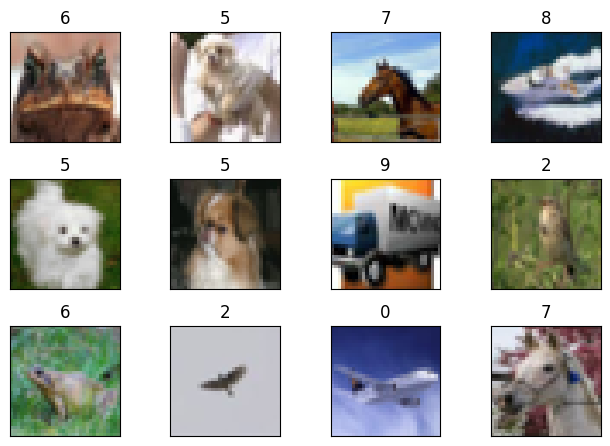

In [9]:
utils.plot_batch_samples(
    data.get_dataloader(
        data.get_dataset({
            'train': transforms.ToTensor(),
            'test': transforms.ToTensor(),
        }),
        params_dataloader,
    )['train']
)

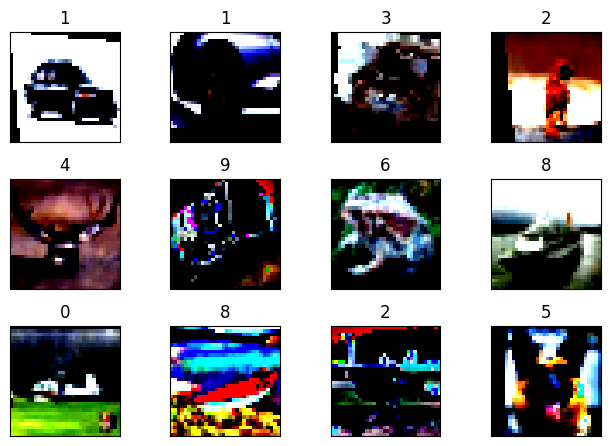

In [10]:
utils.plot_batch_samples(loader['train'])

# Model

In [11]:
params_model = {
    'normalization': 'ln',
    'dropout': 0,
    'groups': 2,
}

criterion = F.nll_loss
model = (
    models
    .Net(
        norm=params_model['normalization'],
        grps=params_model['groups'],
        drop=params_model['dropout'],
    )
    .to(device)
)

summary(
    model,
    input_size=(params_dataloader['batch_size'], *data.CHW),
    row_settings=['var_names'],
)

Layer (type (var_name))                  Output Shape              Param #
Net (Net)                                [128, 10]                 --
├─Sequential (conv1)                     [128, 8, 32, 32]          --
│    └─Conv2d (0)                        [128, 8, 32, 32]          216
│    └─GroupNorm (1)                     [128, 8, 32, 32]          16
│    └─Dropout2d (2)                     [128, 8, 32, 32]          --
│    └─ReLU (3)                          [128, 8, 32, 32]          --
├─SkipBlock (conv2)                      [128, 8, 32, 32]          --
│    └─Conv2d (conv1)                    [128, 8, 32, 32]          576
│    └─GroupNorm (norm1)                 [128, 8, 32, 32]          16
│    └─Dropout2d (drop1)                 [128, 8, 32, 32]          --
│    └─Conv2d (conv2)                    [128, 8, 32, 32]          576
│    └─GroupNorm (norm2)                 [128, 8, 32, 32]          16
│    └─Dropout2d (drop2)                 [128, 8, 32, 32]          --
├─SkipBlock 

# Trainer
- Weight optimizer
- Learning-rate scheduler

In [12]:
params_trainer = {
    'num_epochs': 20,
}
params_optimizer = {
    'lr': 0.5,
    'momentum': 0.9,
}
params_scheduler = {
    'max_lr': params_optimizer['lr'],
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
}

optimizer = optim.SGD(model.parameters(), **params_optimizer)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01614, Accuracy = 21.63%, Epoch = 1
Test : Loss = 0.01429, Accuracy = 32.50%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01467, Accuracy = 29.29%, Epoch = 2
Test : Loss = 0.01330, Accuracy = 36.29%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01359, Accuracy = 35.61%, Epoch = 3
Test : Loss = 0.01197, Accuracy = 44.15%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01286, Accuracy = 39.53%, Epoch = 4
Test : Loss = 0.01136, Accuracy = 47.68%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01238, Accuracy = 42.23%, Epoch = 5
Test : Loss = 0.01083, Accuracy = 50.66%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01152, Accuracy = 46.78%, Epoch = 6
Test : Loss = 0.01023, Accuracy = 53.43%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01088, Accuracy = 49.89%, Epoch = 7
Test : Loss = 0.00919, Accuracy = 58.12%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.01033, Accuracy = 52.98%, Epoch = 8
Test : Loss = 0.00959, Accuracy = 57.78%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00981, Accuracy = 55.09%, Epoch = 9
Test : Loss = 0.00901, Accuracy = 58.19%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00945, Accuracy = 56.94%, Epoch = 10
Test : Loss = 0.00825, Accuracy = 62.10%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00908, Accuracy = 58.58%, Epoch = 11
Test : Loss = 0.00815, Accuracy = 63.27%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00880, Accuracy = 59.97%, Epoch = 12
Test : Loss = 0.00836, Accuracy = 63.19%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00853, Accuracy = 61.28%, Epoch = 13
Test : Loss = 0.00758, Accuracy = 66.16%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00817, Accuracy = 62.79%, Epoch = 14
Test : Loss = 0.00724, Accuracy = 67.83%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00788, Accuracy = 63.95%, Epoch = 15
Test : Loss = 0.00714, Accuracy = 68.14%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00758, Accuracy = 65.77%, Epoch = 16
Test : Loss = 0.00665, Accuracy = 70.25%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00724, Accuracy = 67.44%, Epoch = 17
Test : Loss = 0.00646, Accuracy = 71.28%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00680, Accuracy = 69.38%, Epoch = 18
Test : Loss = 0.00621, Accuracy = 72.15%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00650, Accuracy = 70.65%, Epoch = 19
Test : Loss = 0.00592, Accuracy = 73.34%



  0%|          | 0/391 [00:00<?, ?it/s]

Train: Loss = 0.00636, Accuracy = 71.39%, Epoch = 20
Test : Loss = 0.00585, Accuracy = 73.70%



## LR finder
Find the optimal `max_lr` for the one cycle policy:
- https://sgugger.github.io/the-1cycle-policy.html
- https://iconof.com/1cycle-learning-rate-policy

In [13]:
trn = data.get_dataloader(dataset, params_dataloader)['train']
net = (
    models
    .Net(
        norm=params_model['normalization'],
        grps=params_model['groups'],
        drop=params_model['dropout'],
    )
    .to(device)
)
opt = optim.SGD(net.parameters(), **params_optimizer)
lrs, losses = utils.find_learning_rates(device, trn, net, criterion, opt)

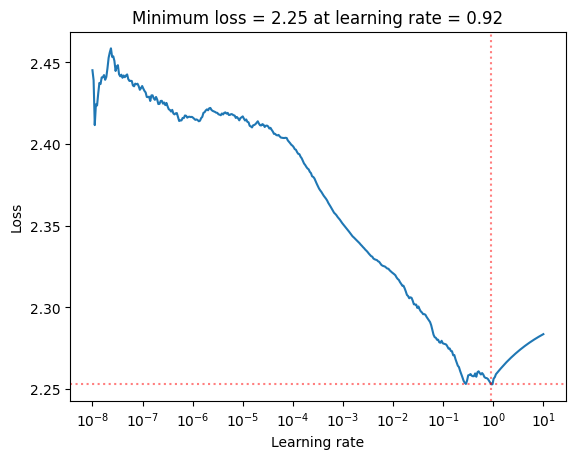

In [14]:
utils.plot_learning_rates(lrs, losses)

# Evaluate

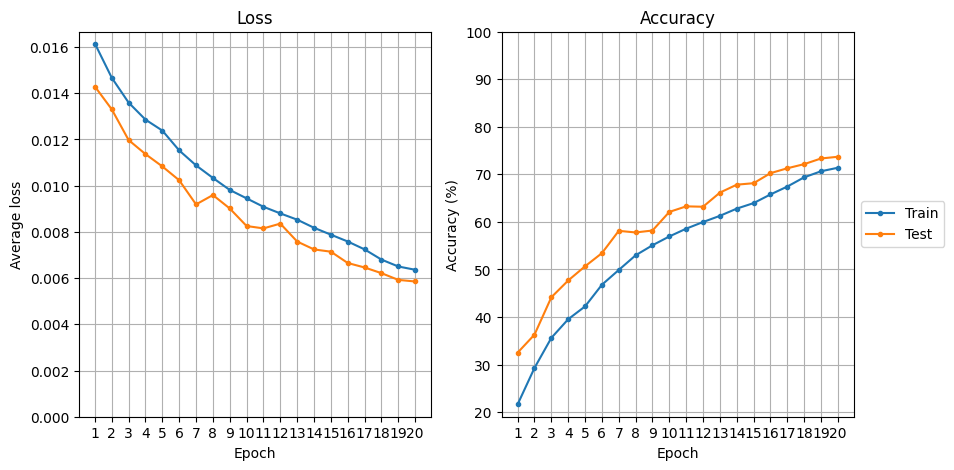

In [15]:
utils.plot_learning_curves(results, params_trainer['num_epochs'])

## Wrong predictions

In [16]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, params_dataloader)['test'],
    model,
    criterion
)

Total Incorrect Predictions 2630


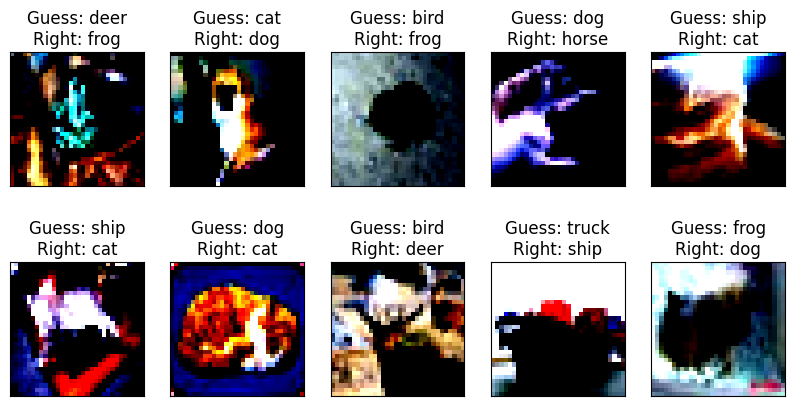

In [17]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)